In [ ]:
#default_exp trainer

# Trainer
> The Trainer class inherits `tf.keras.Model` and contains everything a model needs for training. It exposes `learner.cyclic_fit` method which trains the model using **Cyclic Learning rate** discovered by Leslie Smith.

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from chitra.datagenerator import Dataset

from typeguard import check_argument_types, check_return_type, typechecked
from typing import Union

In [ ]:
#export
from PIL import Image
import numpy as np
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import GradcamPlusPlus, Gradcam
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
#export
import sys, inspect

MODEL_DICT = {}
for name, func in inspect.getmembers(tf.keras.applications):
    if inspect.isfunction(func):
        MODEL_DICT[name.lower()] = func

In [ ]:
#export
@typechecked
def _get_base_cnn(base_model: Union[str, Model],
                 pooling:str='avg',
                 weights:Union[str, None]='imagenet',
                 include_top:bool=False) -> Model:
    if isinstance(base_model, str):
        assert base_model in MODEL_DICT.keys(), f'base_model name must be in {tuple(MODEL_DICT.keys())}'
        base_model = MODEL_DICT[base_model]
        base_model = base_model(include_top=include_top, pooling=pooling, weights=weights)
    return base_model

In [ ]:
#export
@typechecked
def _add_output_layers(base_model: Model, outputs:int,
                      drop_out: Union[float, None]=None, name=None) -> Model:
    
    x = base_model.output
    #x = tf.keras.layers.GlobalMaxPool2D()(x)
    if drop_out:
        x = tf.keras.layers.Dropout(drop_out)(x)
    x = tf.keras.layers.Dense(outputs, name='output')(x)
    
    model = tf.keras.Model(base_model.input, x, name=name)
    return model

In [ ]:
#export
def create_classifier(base_model_fn:callable, num_classes:int,
                      weights='imagenet', dropout=0, 
                      include_top=False, 
                      name=None):
    
    outputs = 1 if num_classes == 2 else num_classes
    
    base_model = base_model_fn(
        include_top=include_top,
        weights=weights,
    )
    if include_top: return base_model
    drop_out = 0.5
    outputs = 1

    x = base_model.output
    x = tf.keras.layers.GlobalMaxPool2D()(x)
    if drop_out:
        x = tf.keras.layers.Dropout(drop_out)(x)
    x = tf.keras.layers.Dense(outputs, name='output')(x)
    
    model = tf.keras.Model(base_model.input, x)
    return model

In [ ]:
#export
@typechecked
def create_cnn(base_model:Union[str, Model],
               num_classes:int,
               drop_out=0.5,
               keras_applications:bool=True,
               pooling:str='avg',
               weights:Union[str, None]='imagenet', name=None) -> Model:
    
    assert pooling in ('avg', 'max')
    
    if keras_applications:
        if num_classes == 2:
            outputs=1
        else:
            outputs = num_classes
    else:
        print(f'num_classes is ignored. returning the passed model as it is.')

    if isinstance(base_model, (str, Model)) and keras_applications:
        base_model = _get_base_cnn(base_model,
                                 pooling=pooling,
                                 weights=weights)
        assert 'pool' in base_model.layers[-1].name, f'base_model last layer must be a pooling layer'
        model = _add_output_layers(base_model, outputs, drop_out=drop_out, name=name)
        
    elif isinstance(base_model, Model) and keras_applications is False:
        model = base_model
    
    elif isinstance(base_model, str) and keras_applications is False:
        model = _get_base_cnn(base_model, weights='imagenet', include_top=True)
    
    else:
        print(f'Invalid arguments!')
    return model

In [ ]:
#export
class Trainer(Model):
    """
    The Trainer class inherits tf.keras.Model and contains everything a model needs for training.
    It exposes learner.cyclic_fit method which trains the model using Cyclic Learning rate discovered by Leslie Smith. 
    
    Arguments:
    ds: Dataset object
    model: object of type tf.keras.Model
    num_classes (int, None): number of classes in the dataset
    
    """
    _AUTOTUNE = tf.data.experimental.AUTOTUNE
            
    @typechecked
    def __init__(self, ds: Dataset, model:Model, num_classes:Union[int, None]=None, **kwargs):
        assert check_argument_types()
        
        super(Trainer, self).__init__()
        self.ds = ds
        self.total = len(ds)
        if num_classes:
            self.NUM_CLASSES = num_classes
        else:
            self.NUM_CLASSES = ds.NUM_CLASSES
        self.gradcam = None        
        self.model = model
        
        
    
    def build(self): pass
         
    def summary(self): return self.model.summary()

    #def get_layer(name=None, index=None): return self.model(name, index)
    
    def compile(self, *args, **kwargs): return self.model.compile(*args, **kwargs)
    
    def call(self, *args, **kwargs): return self.model.call(*args, **kwargs)
    
    def fit(self, *args, **kwargs): return self.model.fit(*args, **kwargs)
    
    def warmup(self):pass
    
    def prewhiten(self, image):
        image = tf.cast(image, tf.float32)
        image = image / 127.5 - 1.0
        return image
    
    def rescale(self, image, label):
        image = self.prewhiten(image)
        return image, label
    
    def _get_optimizer(self,
                       optimizer,
                       momentum=0.9,
                       **kwargs
                      ):
        if optimizer.__name__=='SGD':
            optimizer = partial(optimizer,
                momentum=momentum,
                nesterov=kwargs.get('nesterov', True)
            )
        else:
            optimizer = partial(optimizer,
                momentum=momentum,
            )
        return optimizer
    
    
    def _prepare_dl(self, bs=8, shuffle=True):
        ds = self.ds
        dl = ds.get_tf_dataset(shuffle=shuffle)
        dl = dl.map(self.rescale, Trainer._AUTOTUNE)
        return dl.batch(bs).prefetch(Trainer._AUTOTUNE)

    
    def cyclic_fit(self,
                   epochs,
                   batch_size,
                   lr_range=(1e-4, 1e-2),
                   optimizer=tf.keras.optimizers.SGD,
                   momentum=0.9,
                   validation_data=None,
                   callbacks=None,
                   *args,
                   **kwargs
                  ):
        """Trains model on ds as train data with cyclic learning rate.
        Dataset will be automatically converted into `tf.data` format and images will be prewhitened in range of [-1, 1].
        """
        
        self.max_lr, self.min_lr = lr_range
        ds = self.ds
        
        step_size = 2 * len(self.ds)//batch_size
        
        lr_schedule = tfa.optimizers.Triangular2CyclicalLearningRate(
                                    initial_learning_rate=lr_range[0],
                                    maximal_learning_rate=lr_range[1],
                                    step_size=kwargs.get('step_size', step_size),
                                    scale_mode=kwargs.get('scale', 'cycle'))
        
        
        optimizer = self._get_optimizer(optimizer, momentum=momentum)
        optimizer = optimizer(learning_rate=lr_schedule)
        self.model.optimizer = optimizer
        
        return self.model.fit(
            self._prepare_dl(batch_size, kwargs.get('shuffle', True)),
            validation_data=validation_data,
            epochs=epochs,
            callbacks=callbacks
        )
    
    def gradcam(self, image:Image.Image, image_size=None):
        # assert check_argument_types()
        
        def model_modifier(m):
            """Converts sigmoid to linear
            """
            m.layers[-1].activation = tf.keras.activations.linear
            return m
        
        
        if image_size:
            image_size = self.ds.img_sz_list.get_size()
        image = image.resize(image_size)
        
        X = np.asarray(image, np.float32)
        X = self.prewhiten(X)
        X = np.expand_dims(X, 0)
        
        if self.gradcam is None:
            self.gradcam = Gradcam(self.model,
                              model_modifier,
                              clone=True)
        
        cam = gradcam(get_loss,
              X,
              penultimate_layer=-1, # model.layers number
              seek_penultimate_conv_layer=False,
          
             )
        

In [ ]:
#export
class InterpretModel():
    def __init__(self, gradcam_pp:bool, learner:Trainer, clone:bool=False):
        """Args:
        gradcam_pp: if True GradCam class will be used else GradCamPlusplus
        clone: whether GradCam will clone learner.model
        """
        if gradcam_pp:
            self.gradcam_fn = GradcamPlusPlus
        else:
            self.gradcam_fn = Gradcam
        self.learner = learner
    
        self.gradcam = self.gradcam_fn(learner.model,
                                      self.model_modifier,
                                      clone=clone)
    
        # if self.learner.include_top is not True:
        #     self.gradcam._find_penultimate_output = self.patch
        
            
    def __call__(self, image:Image.Image, auto_resize:bool=True, image_size=None):
        #assert check_argument_types()
        gradcam = self.gradcam
        get_loss = self.get_loss
        if auto_resize and image_size is None:
            image_size = self.learner.ds.img_sz_list.get_size()
        if image_size:
            image = image.resize(image_size)
        
        X = np.asarray(image, np.float32)
        X = self.learner.prewhiten(X)
        X = np.expand_dims(X, 0)
        
        cam = gradcam(get_loss,
                      X,
                      penultimate_layer=-1, # model.layers number
                      seek_penultimate_conv_layer=True,
                     )
        cam = normalize(cam)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        plt.imshow(image)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.show()
        
    
    def __patch(self, *args, **kwargs):
        """Path _find_penultimate_output method of tf_keras_vis"""
        if self.learner.include_top:
            return self.learner.model.layers[-1].output
        return self.learner.model.layers[0].get_output_at(-1)
    
    
    def model_modifier(self, m):
        """Sets last activation to linear
        """
        m.layers[-1].activation = tf.keras.activations.linear
        return m
    
    def get_loss(self, preds):
        if self.learner.NUM_CLASSES == 2:
            ret = preds[0]
        else:
            index = tf.argmax(tf.math.softmax(preds), axis=1)[0]
            # print(index, preds.shape)
            ret = preds[0, index]
            print(f'index: {index}')
        return ret

In [ ]:
# path = '/data/aniket/tiny-imagenet/data/tiny-imagenet-200/train'
path = '/Users/aniket/Pictures/data/train'

In [ ]:
from glob import glob
from chitra.core import IMAGENET_LABELS

def load_files(path):
    return glob(f'{path}/*/images/*')

def get_label(path):
    return path.split('/')[-3]


ds = Dataset(path)

No item present in the image size list


In [ ]:
model = create_cnn(tf.keras.applications.MobileNetV2(include_top=True), 1000, keras_applications=False)

num_classes is ignored. returning the passed model as it is.


In [ ]:
trainer = Trainer(ds=ds, model=model, num_classes=1000)

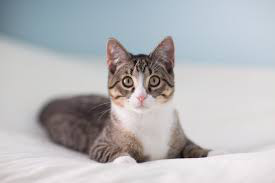

In [ ]:
interpret = InterpretModel(False, trainer)

# path = '/data/aniket/tiny-imagenet/data/tiny-imagenet-200/train/n01641577/images/n01641577_100.JPEG'
path  = '/Users/aniket/Pictures/data/train/cat/2.jpeg'
image = Image.open(path);image

index: 285


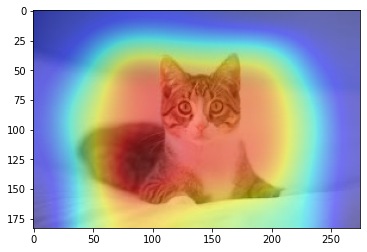

In [ ]:
interpret(image, auto_resize=False)

In [ ]:
IMAGENET_LABELS[285]

'Egyptian Mau'

In [ ]:
#hide
# from nbdev.export import notebook2script;notebook2script('06_trainer.ipynb')

Converted 06_trainer.ipynb.
